# Aim

This notebook contains a bit of data exploration regarding the Fluorescent Neuronal Cells collection, with some summary statistics reported in the paper.

### Imports

Imports and settings.

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
from itertools import product

from IPython import get_ipython
from IPython.core.interactiveshell import InteractiveShell

from skimage import io
from matplotlib import pyplot as plt

# import warnings
# warnings.filterwarnings('ignore')


# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30
pd.options.display.float_format = '{:,.2f}'.format

# Display all cell outputs
InteractiveShell.ast_node_interactivity = 'all'

ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
size = 14
params = {'legend.fontsize': 'large',
          'font.family': "Helvetica",
          'figure.figsize': (8, 8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.9,
          'ytick.labelsize': size*0.9,
          # 'axes.titlepad': 25
          }
plt.rcParams.update(params)

plt.style.use('seaborn-whitegrid')
# alternative to the above
# plt.rcParams["axes.grid"] = True
# plt.rcParams["axes.grid.which"] = "both"
# plt.rcParams["axes.linewidth"] = 0.5
# plt.rcParams["grid.linestyle"] = "--"
# plt.rcParams["grid.alpha"] = 0.5

/tmp/ipykernel_47826/2225115543.py:46: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [2]:
import sys
code_path = "../"
sys.path.append(code_path)
from fluocells.config import REPO_PATH, DATA_PATH, DATA_PATH_g, DATA_PATH_y, DATA_PATH_r, METADATA

# Visual Inspection

Let's first visualize some images and binary masks for each dataset.

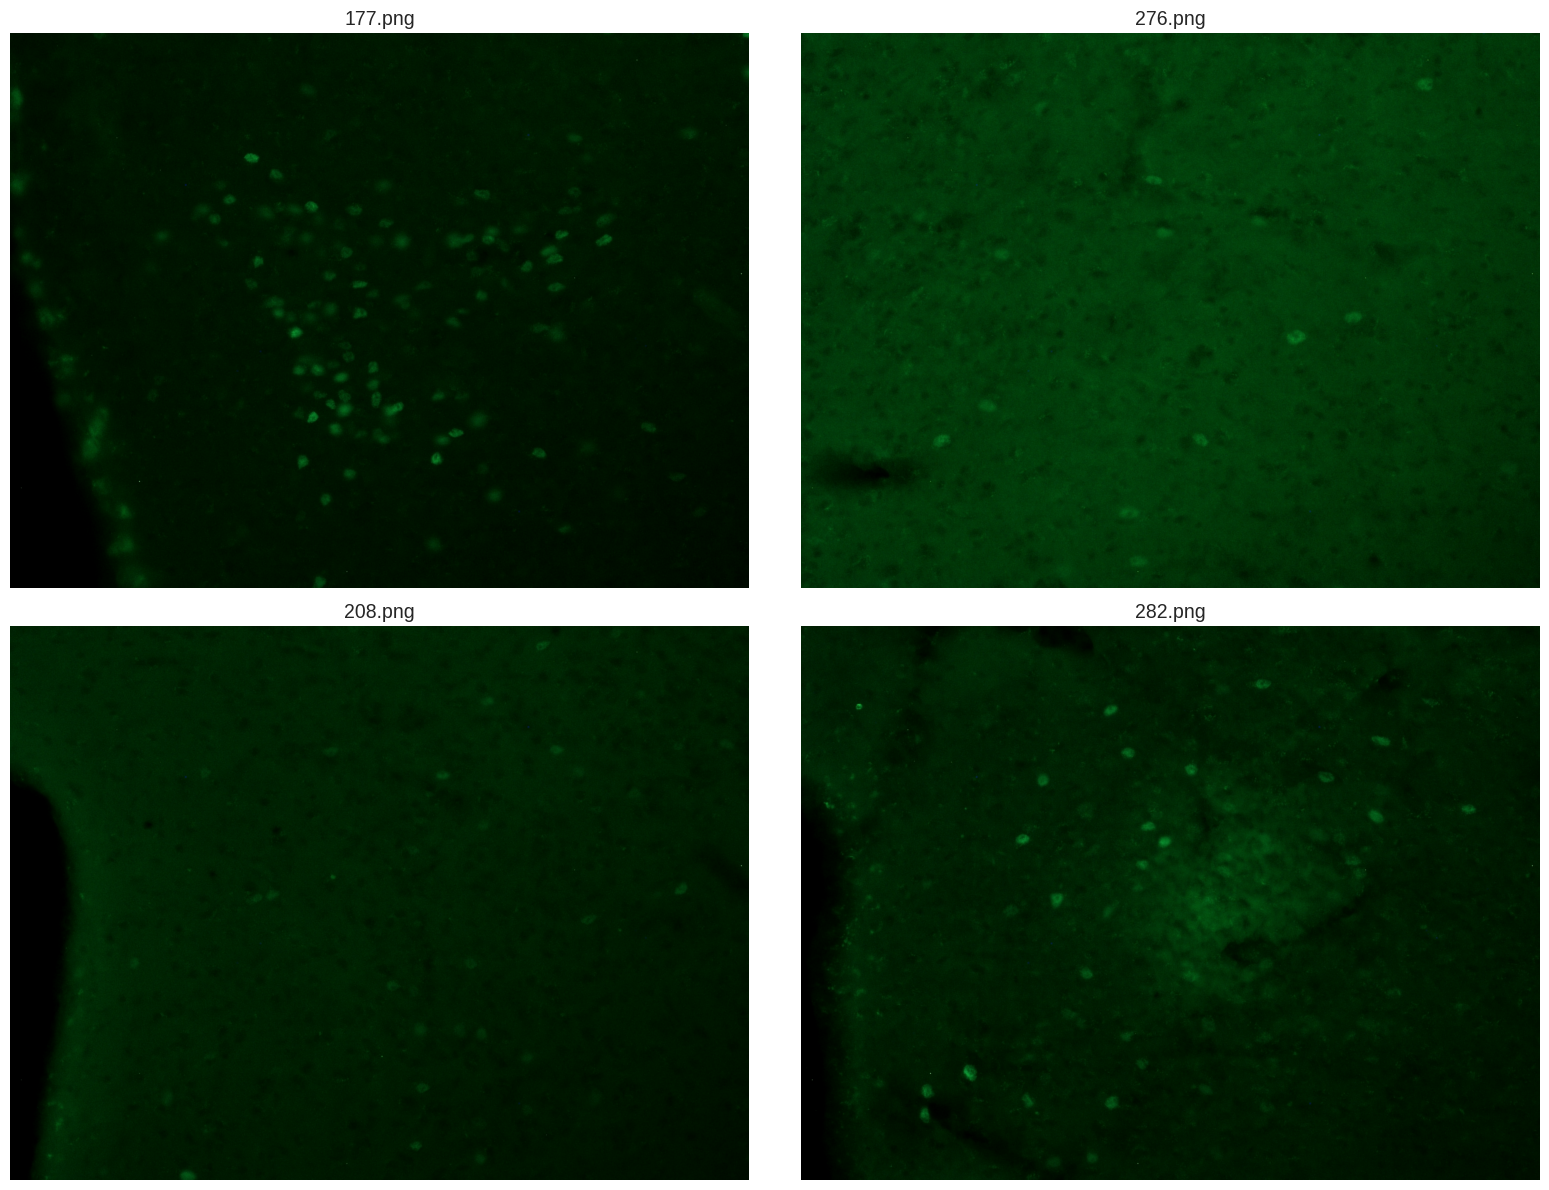

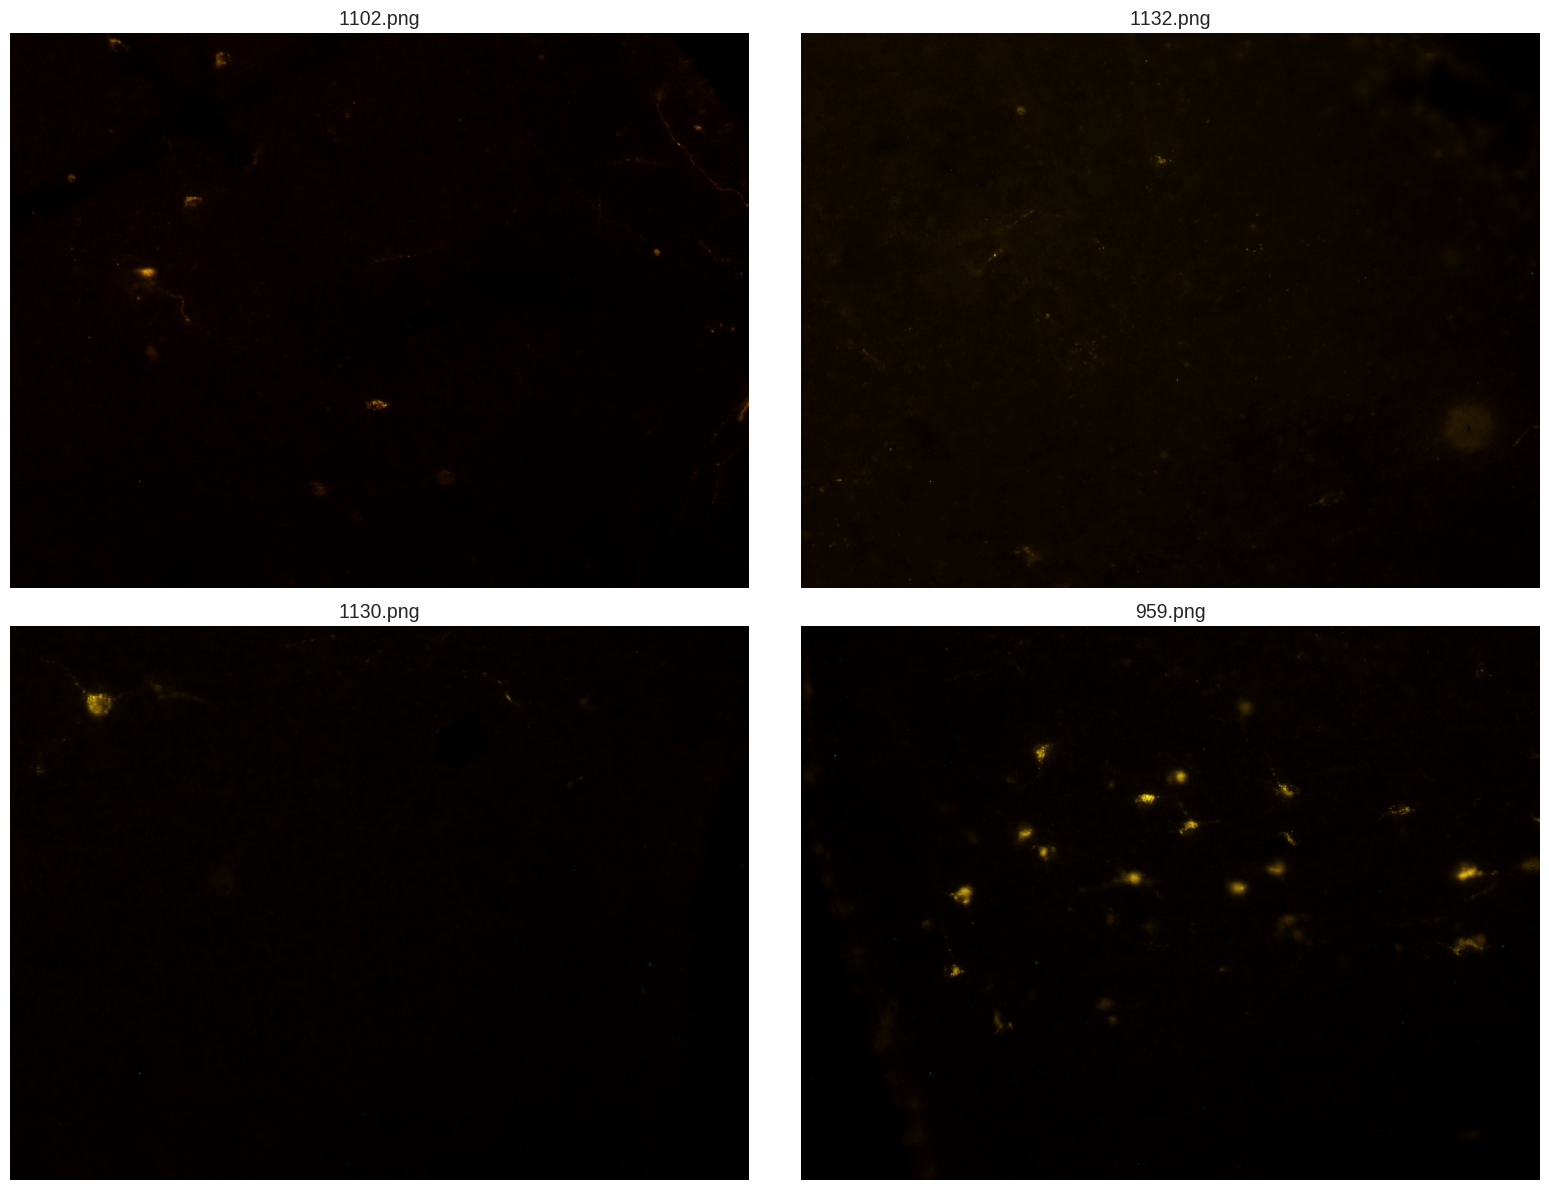

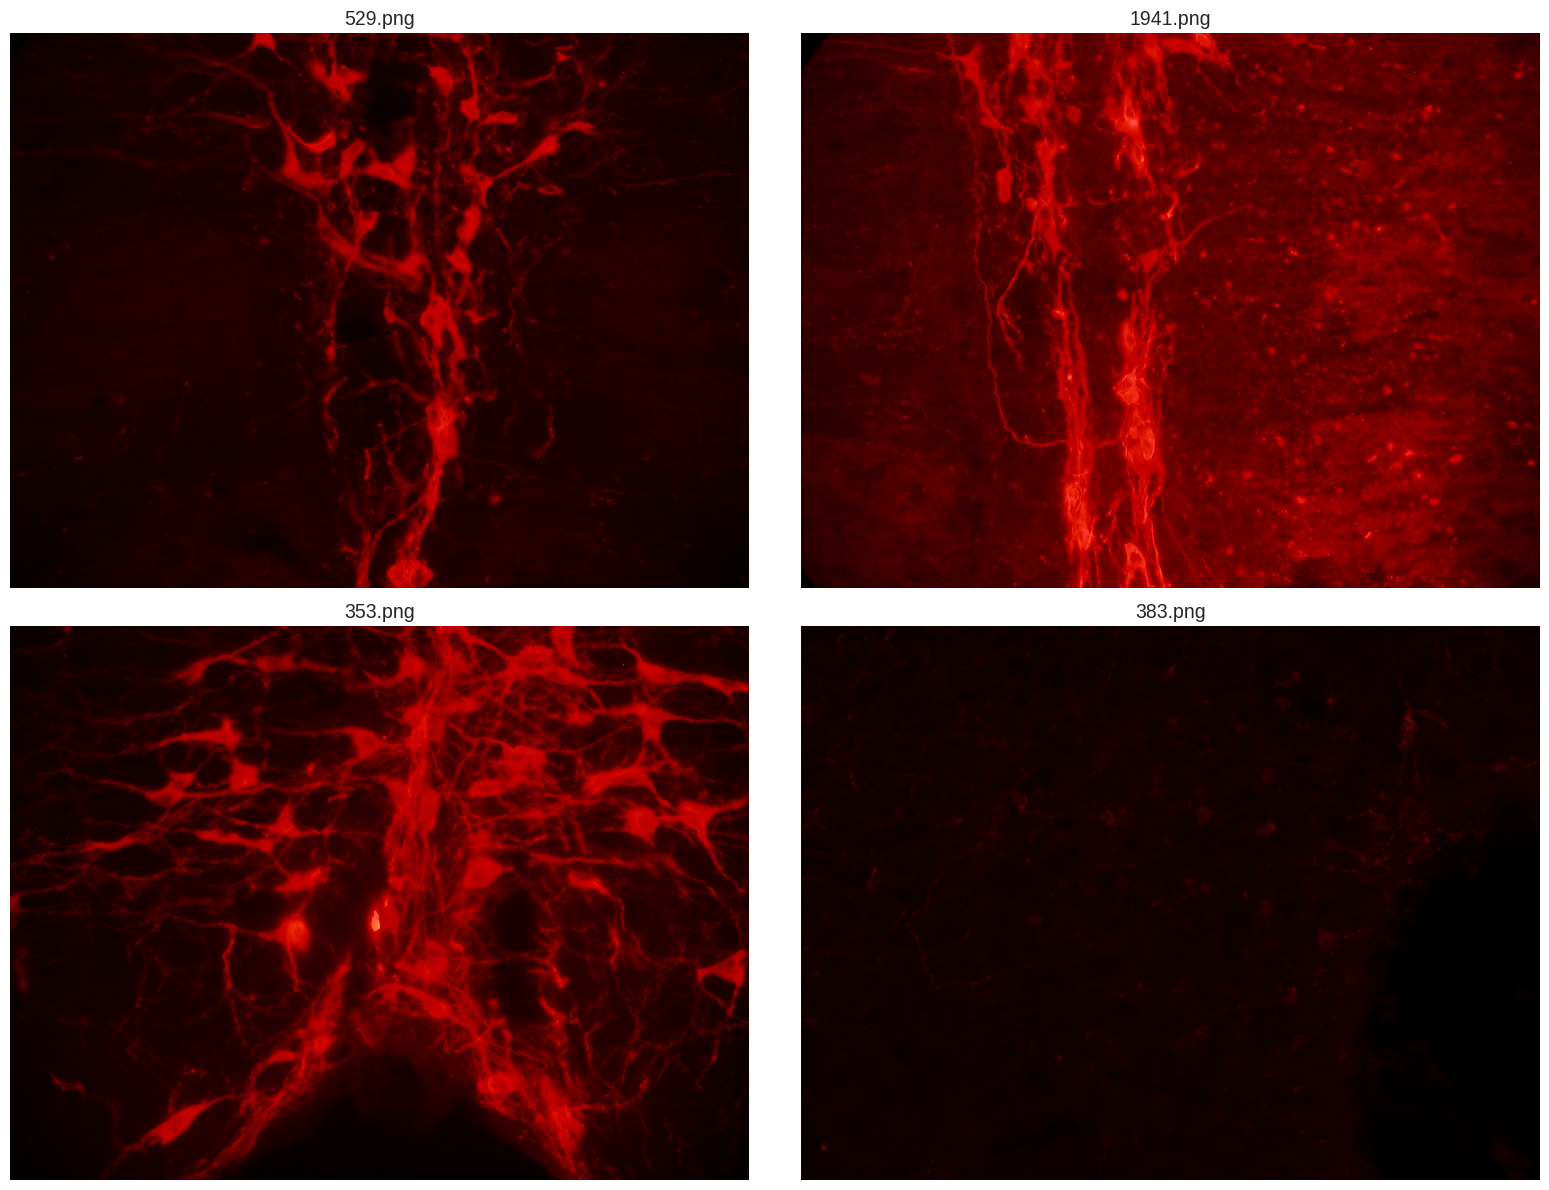

In [3]:
for dataset_path in [DATA_PATH_g, DATA_PATH_y, DATA_PATH_r]:
    sample_data_path = dataset_path / 'trainval' / 'images'
    fig = plt.figure(figsize=(16, 12))
    for i, img_path in enumerate([*sample_data_path.iterdir()][:4]):
        img = io.imread(img_path)
        sb = plt.subplot(2, 2, i+1)
        plot = plt.title(img_path.name)
        plot = plt.axis('off')
        plot = plt.imshow(img)
    plt.tight_layout()
    plt.show()

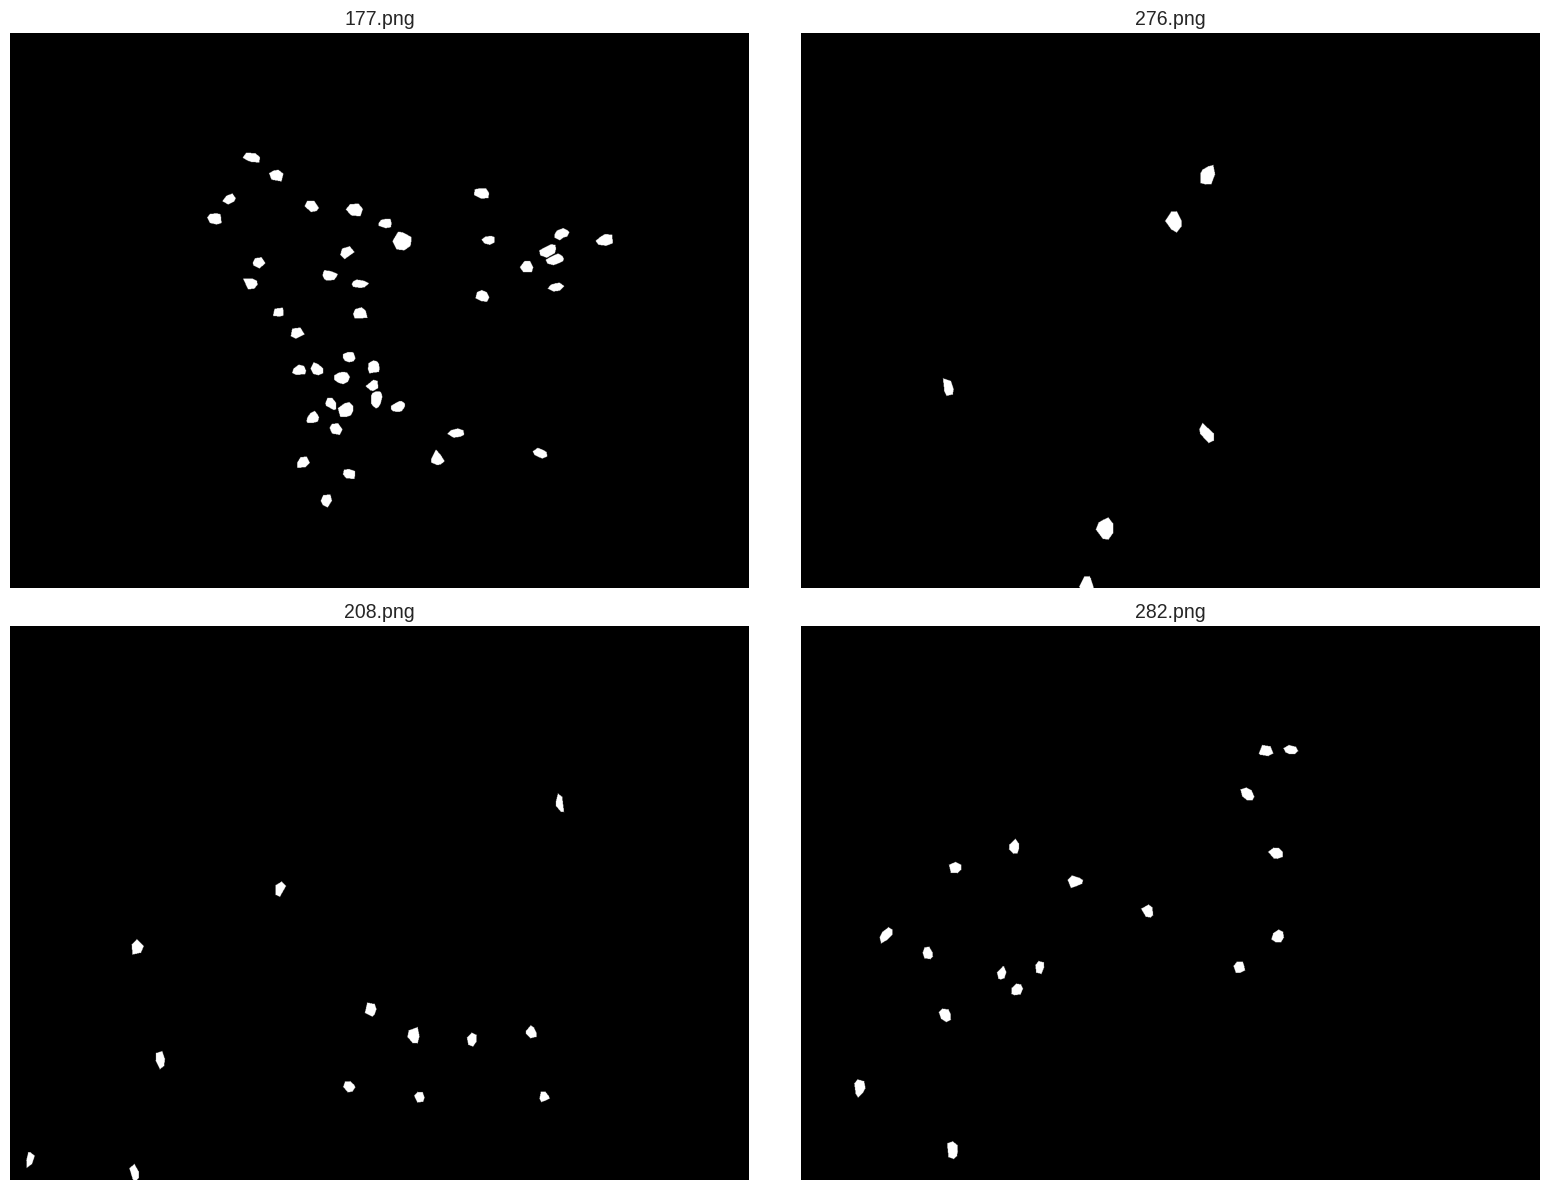

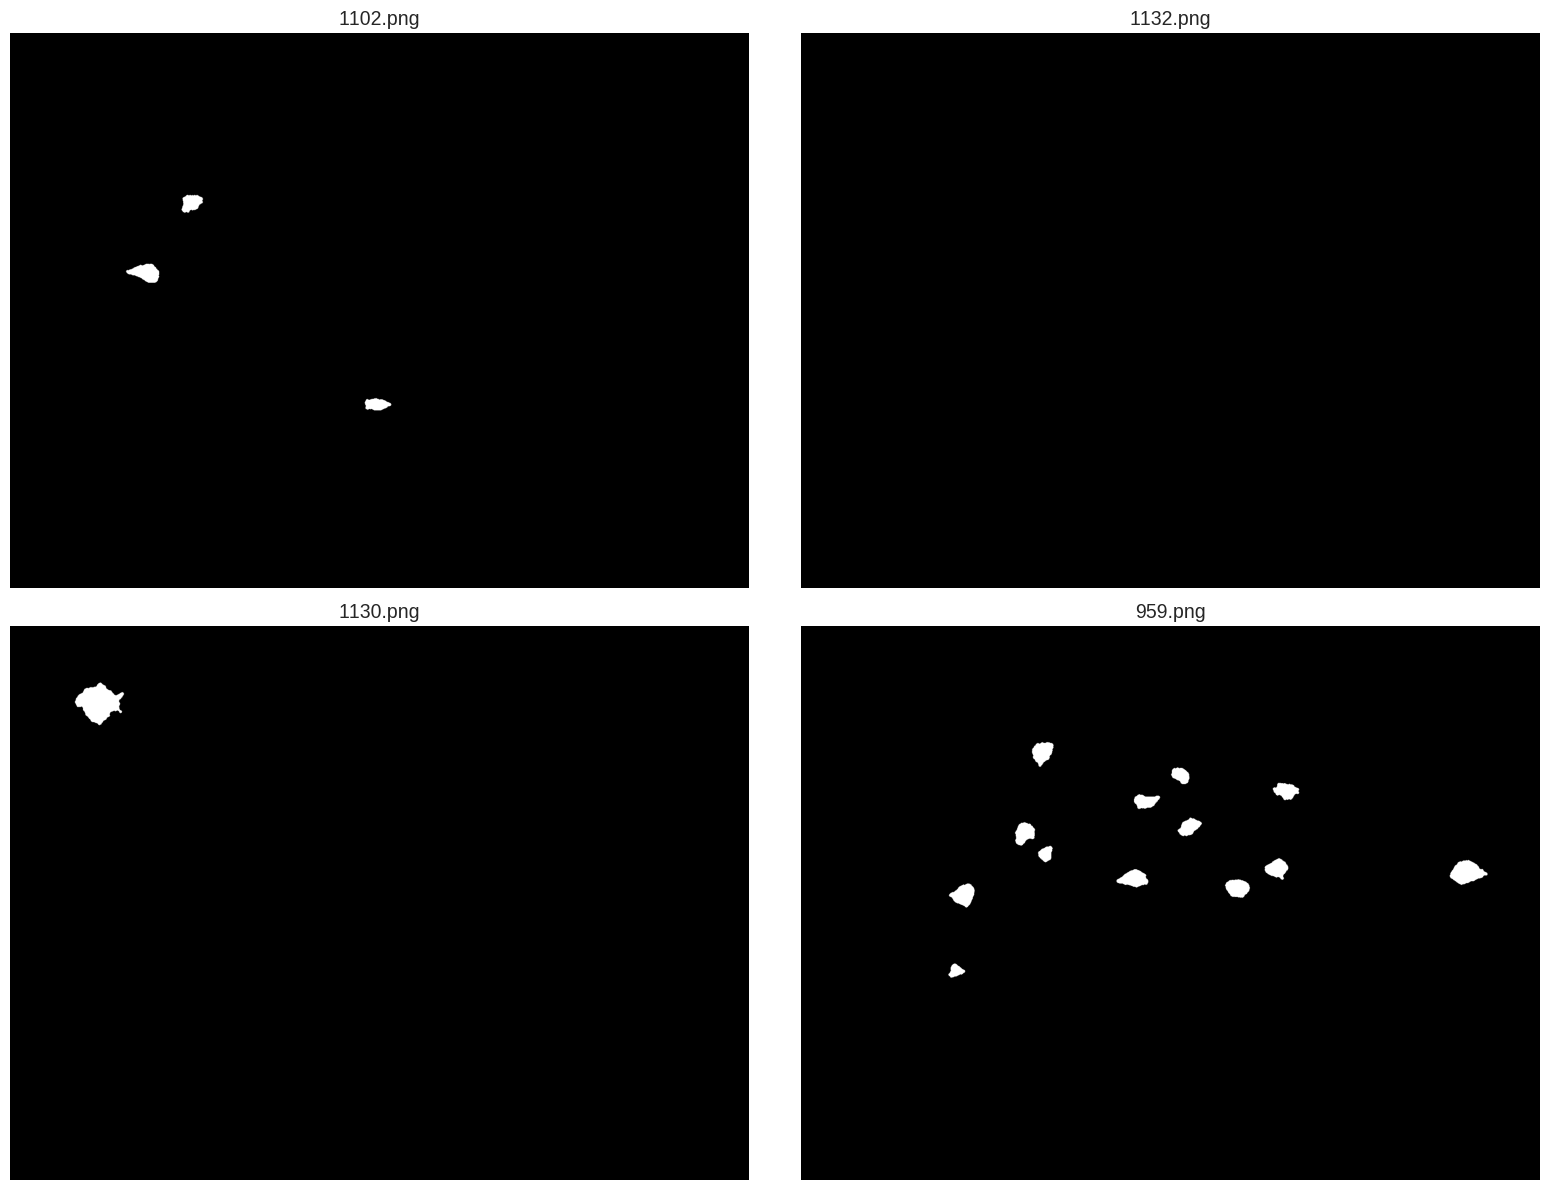

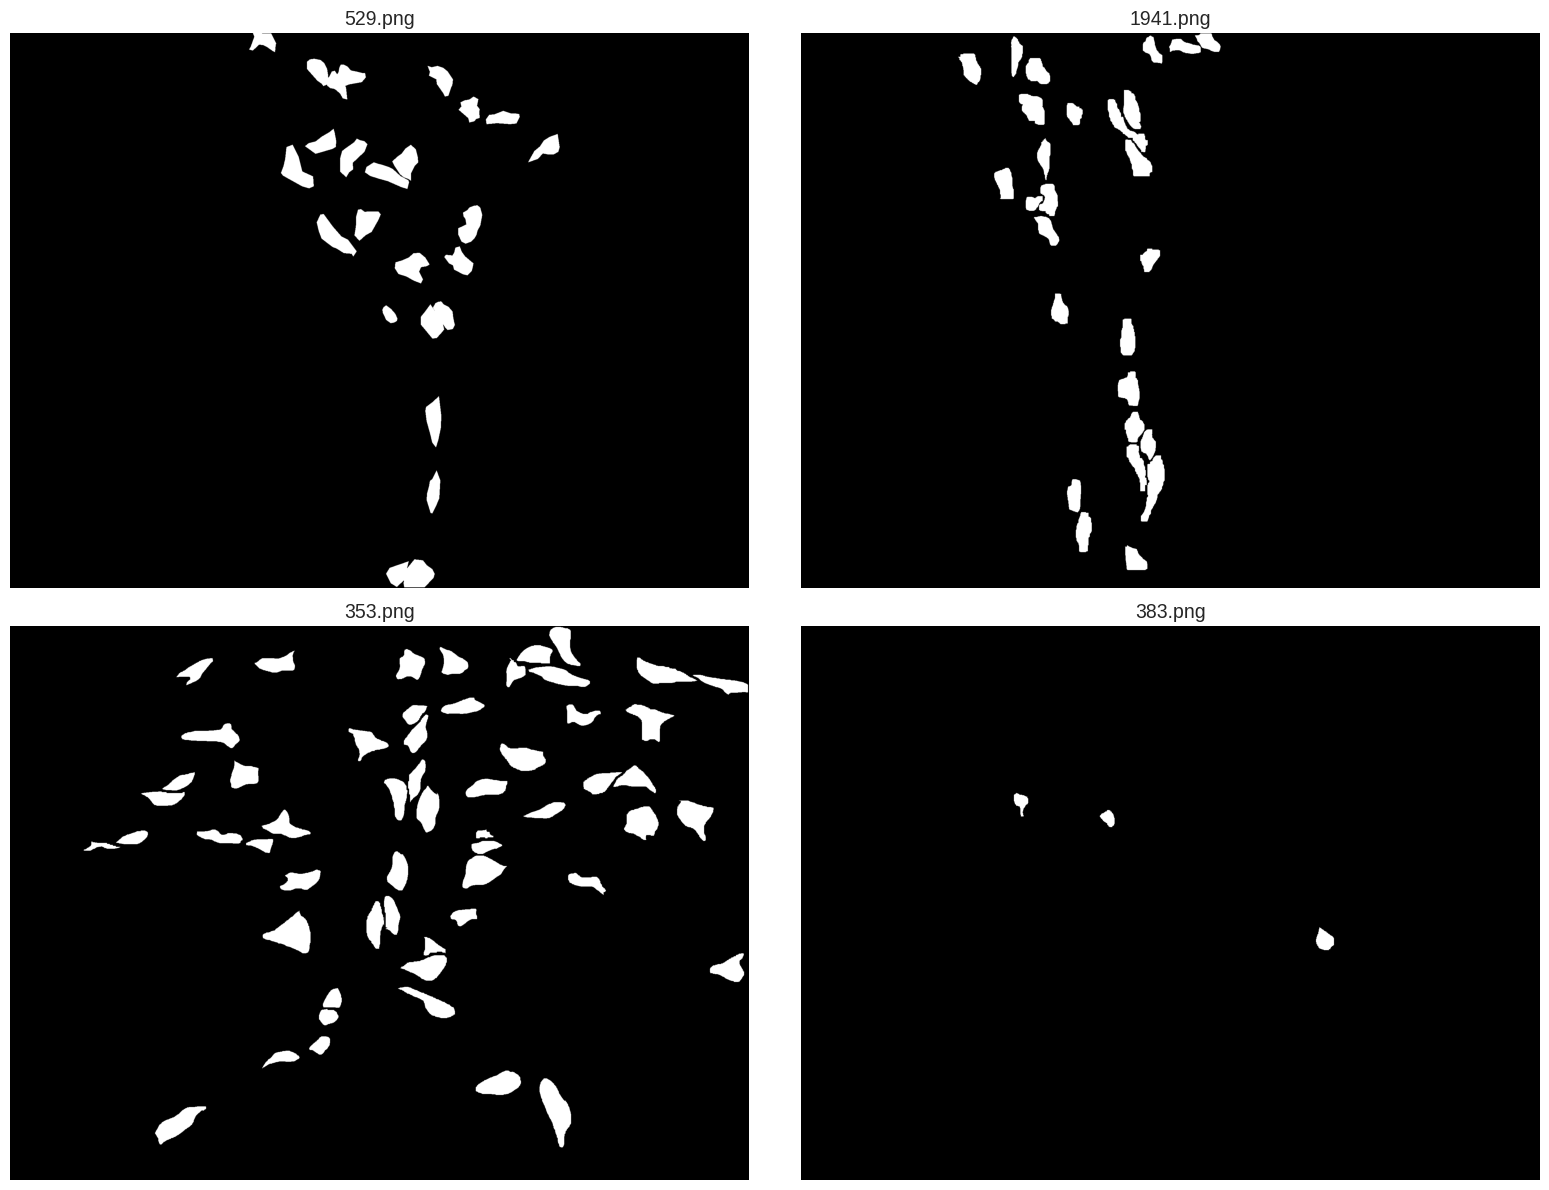

In [4]:
for dataset_path in [DATA_PATH_g, DATA_PATH_y, DATA_PATH_r]:
    sample_data_path = dataset_path / 'trainval' / 'ground_truths/masks'
    fig = plt.figure(figsize=(16, 12))
    for i, img_path in enumerate([*sample_data_path.iterdir()][:4]):
        img = io.imread(img_path, as_gray=True)
        sb = plt.subplot(2, 2, i+1)
        plot = plt.title(img_path.name)
        plot = plt.axis('off')
        plot = plt.imshow(img, cmap="gray")
    plt.tight_layout()
    plt.show()

# Summary statistics

In [5]:
# read metadata
meta_df = pd.read_excel(DATA_PATH_y.parent / f"metadata_{METADATA['current_version']}.xlsx", sheet_name="metadata")


# Get summary stats and rearrange df for plotting
df_stats = meta_df.groupby(['dataset', 'partition'])['image_name'].size().reset_index(name='total')
df_stats

dataset   partition  total
0   green        test     70
1   green    trainval    213
2   green  unlabelled    408
3     red        test     46
4     red    trainval    138
5     red  unlabelled    362
6  yellow        test     70
7  yellow    trainval    213
8  yellow  unlabelled    361

## Size

In [6]:
total_images = len(meta_df)
total_labelled = len(meta_df.query("partition != 'unlabelled'"))
total_unlabelled = len(meta_df.query("partition == 'unlabelled'"))

print(f"{total_images=}")
print(f"{total_labelled=}")
print(f"{total_unlabelled=}")

total_images=1881
total_labelled=750
total_unlabelled=1131


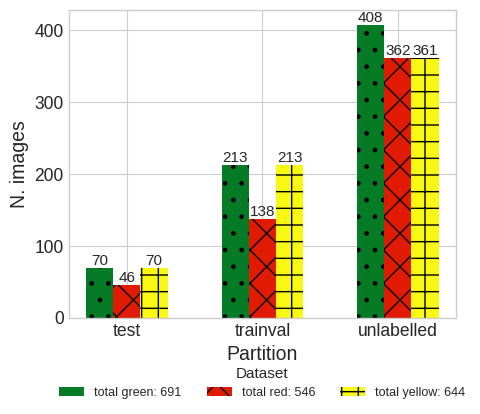

In [7]:
# labelling utils
datasets = ["green", "red", "yellow"]
sizes = df_stats.groupby("dataset")["total"].sum().values
colors = {"green": '#067b26', "red": '#e11b01', "yellow": '#f9f814'}
patterns = {"green": '.', "red": 'x', "yellow": '+'}
labels = [f"total {dataset}: {size}" for dataset, size in zip(datasets, sizes)]

# Plot
annotations_size = 11 #int(size*2/3)

width = 0.2
x = np.arange(len(df_stats['partition'].unique()))

fig, ax = plt.subplots(figsize=(5, 4))
colors = ['#067b26', '#e11b01', '#f9f814']
patterns = [".", "x", "+"]
h = 0
for i, (group, data) in enumerate(df_stats.groupby('dataset')):
    xs = x + (i - 1) * width
    _ = ax.bar(xs, data['total'], width=width, label=group, color=colors[i], hatch=patterns[i])
    for j, count in enumerate(data['total']):
        _ = ax.text(xs[j], count, str(count), ha='center', va='bottom', size=annotations_size)

# Set custom x-axis tick labels
_ = ax.set_xticks(x)
_ = ax.set_xticklabels(df_stats['partition'].unique())

# Set labels and title
_ = ax.set_xlabel('Partition')
_ = ax.set_ylabel('N. images')
# _ = ax.set_title('FNC collection composition')
_ = ax.legend(title='Dataset')
 
# Set layout for consistent outlook
_ = fig.patch.set_alpha(0)
_ = ax.patch.set_alpha(0)

# Move the legend outside and set custom labels
_ = ax.legend(title='Dataset', bbox_to_anchor=(0.5, -0.3), loc='lower center', ncol=len(df_stats['dataset'].unique()),fancybox=True, shadow=True, labels=labels, title_fontsize=annotations_size, fontsize=annotations_size-2)
# Save the plot as PDF
fig.savefig(REPO_PATH / "figures" / "FNC_composition.pdf", bbox_inches='tight')
plt.show()


## Class imbalance

In [10]:
all_mask_paths = []
for dataset, partition in product(["green", "red", "yellow"], ["trainval", "test"]):
    all_mask_paths.extend([*(DATA_PATH / dataset / partition / "ground_truths/masks").iterdir()])
    
signal_pct_df = pd.DataFrame()
for mask_path in tqdm(all_mask_paths):
    mask = io.imread(mask_path, as_gray=True)
    total_pixels = mask.shape[0]*mask.shape[1]
    
    partition = mask_path.parent.parent.parent.name
    dataset = mask_path.parent.parent.parent.parent.name
    
    # check binary masks
    if len(np.unique(mask)) > 2:
        print(mask_path.name)
        print(np.unique(mask))
        raise(NotImplementedError)

    # check masks are in [0, 255] format
    if mask.max() != 255 and 0:
        # mask = mask/mask.max()
        raise(NotImplementedError)

    ones = mask.astype('bool').sum()
    zeros = total_pixels - ones
    values, counts = [0, 1], [zeros, ones]
    
    image_signal_stats = pd.DataFrame([[mask_path.name, dataset, partition, zeros, ones, total_pixels ]], 
                                      columns=["image_name", "dataset", "partition", "zeros", "ones", "total"])
    signal_pct_df = pd.concat([signal_pct_df, image_signal_stats], axis=0)
    
    # signal_pct_df.append(pd.Series(
    #     [mask_path.name, dataset, partition, zeros, ones, total_pixels ], 
    #     index=signal_pct_df.columns
    #     ), ignore_index=True)


  0%|          | 0/750 [00:00<?, ?it/s]

In [11]:
eps = 1
qq = [0.1, 0.25, 0.5, 0.75, 0.9]

signal_pct_df['class0_to_total'] = signal_pct_df["zeros"]/signal_pct_df["total"]*100
signal_pct_df['class1_to_total'] = signal_pct_df["ones"]/signal_pct_df["total"]*100
# signal_pct_df['background_to_signal'] = signal_pct_df["zeros"]/(signal_pct_df["ones"]+eps)

signal_pct_df['zeros'] = signal_pct_df['zeros'].astype(int)
signal_pct_df['ones'] = signal_pct_df['ones'].astype(int)
signal_pct_df['total'] = signal_pct_df['total'].astype(int)
signal_pct_df['class0_to_total'] = signal_pct_df['class0_to_total'].astype(float)
signal_pct_df['class1_to_total'] = signal_pct_df['class1_to_total'].astype(float)

# signal_pct_df.head()

summary = signal_pct_df.groupby(["dataset", "partition"]).describe(percentiles=qq)
summary

zeros                                                    \
                   count         mean        std          min          10%   
dataset partition                                                            
green   test       70.00 1,909,015.77   9,925.01 1,873,908.00 1,896,095.80   
        trainval  213.00 1,908,982.68   9,945.48 1,855,534.00 1,896,707.00   
red     test       46.00 3,142,161.52 891,018.40 1,764,604.00 1,874,709.00   
        trainval  138.00 3,116,909.73 887,592.72 1,800,094.00 1,876,188.60   
yellow  test       70.00 1,904,200.97  20,131.77 1,809,583.00 1,886,648.00   
        trainval  213.00 1,910,151.69  10,616.17 1,854,529.00 1,897,938.40   

                                                                       \
                           25%          50%          75%          90%   
dataset partition                                                       
green   test      1,904,547.00 1,912,291.50 1,916,018.00 1,918,499.00   
        trainval  1,904,822.00 1,912,120.00 1,915,694.00 1,918,015.40   
red     test      1,914,677.75 3,699,446.50 3,786,233.75 3,824,628.00   
        trainval  1,912,931.00 3,716,840.50 3,782,266.25 3,803,937.80   
yellow  test      1,902,010.75 1,909,242.00 1,915,417.75 1,920,000.00   
        trainval  1,905,610.00 1,912,530.00 1,918,242.00 1,920,000.00   

                                 ones                                       \
                           max  count      mean       std    min       10%   
dataset partition                                                            
green   test      1,920,000.00  70.00 10,984.23  9,925.01   0.00  1,501.00   
        trainval  1,920,000.00 213.00 11,017.32  9,945.48   0.00  1,984.60   
red     test      3,871,488.00  46.00 92,971.70 76,030.69   0.00 14,066.50   
        trainval  3,838,530.00 138.00 89,941.05 64,817.93 746.00  7,234.30   
yellow  test      1,920,000.00  70.00 15,799.03 20,131.77   0.00      0.00   
        trainval  1,920,000.00 213.00  9,848.31 10,616.17   0.00      0.00   

                                                                        total  \
                        25%       50%        75%        90%        max  count   
dataset partition                                                               
green   test       3,982.00  7,708.50  15,453.00  23,904.20  46,092.00  70.00   
        trainval   4,306.00  7,880.00  15,178.00  23,293.00  64,466.00 213.00   
red     test      36,558.50 70,391.50 143,926.50 200,377.50 315,250.00  46.00   
        trainval  43,911.25 79,424.00 130,895.50 177,833.10 271,990.00 138.00   
yellow  test       4,582.25 10,758.00  17,989.25  33,352.00 110,417.00  70.00   
        trainval   1,758.00  7,470.00  14,390.00  22,061.60  65,471.00 213.00   

                                                                     \
                          mean        std          min          10%   
dataset partition                                                     
green   test      1,920,000.00       0.00 1,920,000.00 1,920,000.00   
        trainval  1,920,000.00       0.00 1,920,000.00 1,920,000.00   
red     test      3,235,133.22 924,926.43 1,920,000.00 1,920,000.00   
        trainval  3,206,850.78 928,187.43 1,920,000.00 1,920,000.00   
yellow  test      1,920,000.00       0.00 1,920,000.00 1,920,000.00   
        trainval  1,920,000.00       0.00 1,920,000.00 1,920,000.00   

                                                                       \
                           25%          50%          75%          90%   
dataset partition                                                       
green   test      1,920,000.00 1,920,000.00 1,920,000.00 1,920,000.00   
        trainval  1,920,000.00 1,920,000.00 1,920,000.00 1,920,000.00   
red     test      1,920,000.00 3,871,488.00 3,871,488.00 3,871,488.00   
        trainval  1,920,000.00 3,871,488.00 3,871,488.00 3,871,488.00   
yellow  test      1,920,000.00 1,920,000.00 1,920,000.00 1,920,000.00   
 

In [12]:
def _create_multiindex(var):
    
    idx = pd.MultiIndex.from_tuples([
        ('variable', '', ''),
        (var, 'green', 'test'),
        (var, 'green', 'trainval'),
        (var, 'red', 'test'),
        (var, 'red', 'trainval'),
        (var, 'yellow', 'test'),
        (var, 'yellow', 'trainval')
    ], names=['feature', 'dataset', 'partition']
                        )
    return idx


summary_table = summary.transpose().reset_index().set_index('level_1')
summary_table = summary_table[summary_table.level_0=="class1_to_total"]
idx = _create_multiindex("signal %")
summary_table.columns = idx
summary_table.drop("variable", axis=1, inplace=True)
summary_table

/tmp/ipykernel_47826/3222140168.py:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  summary_table.drop("variable", axis=1, inplace=True)


feature   signal %                                        
dataset      green            red          yellow         
partition     test trainval  test trainval   test trainval
level_1                                                   
count        70.00   213.00 46.00   138.00  70.00   213.00
mean          0.57     0.57  2.75     2.61   0.82     0.51
std           0.52     0.52  2.04     1.67   1.05     0.55
min           0.00     0.00  0.00     0.04   0.00     0.00
10%           0.08     0.10  0.51     0.38   0.00     0.00
25%           0.21     0.22  1.30     1.38   0.24     0.09
50%           0.40     0.41  2.30     2.41   0.56     0.39
75%           0.80     0.79  4.22     3.74   0.94     0.75
90%           1.25     1.21  5.22     4.81   1.74     1.15
max           2.40     3.36  8.14     7.03   5.75     3.41

## Object features

In [13]:
%autoreload 2
from fluocells.utils.data import compute_masks_stats

cell_stats_df = compute_masks_stats(all_mask_paths)

  0%|          | 0/750 [00:00<?, ?it/s]

In [14]:
# convert from pixel to um based on resolution from metadata
def _convert_pixels_to_micron(stats_df, meta_df):
    _temp = pd.merge(stats_df, meta_df[["image_name", "resolution_px_um"]], on="image_name")
    # we need to divide twice for the area (um^2)
    stats_df.loc[:, "area"] = stats_df["area"] / _temp["resolution_px_um"]
    return stats_df[stats_df.columns[1:]].div(_temp["resolution_px_um"], axis=0)


meta_df = pd.read_excel(DATA_PATH / f"metadata_{METADATA['current_version']}.xlsx", sheet_name="metadata")
cell_stats_df_copy = cell_stats_df.copy()
measure_cols = list(cell_stats_df_copy.columns[5:])
cell_stats_df_copy[cell_stats_df_copy.columns[5:]] = _convert_pixels_to_micron(cell_stats_df_copy[["image_name"]+measure_cols], meta_df)
cell_stats_df_copy

/tmp/ipykernel_47826/4134406744.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats_df.loc[:, "area"] = stats_df["area"] / _temp["resolution_px_um"]


image_name dataset partition  n_cells  cell_id   area  min_axis_length  \
0        177.png   green  trainval    43.00     0.00  55.92             6.15   
1        177.png   green  trainval    43.00     1.00  53.85             7.41   
2        177.png   green  trainval    43.00     2.00  57.50             7.02   
3        177.png   green  trainval    43.00     3.00  39.97             6.01   
4        177.png   green  trainval    43.00     4.00  50.21             6.93   
...          ...     ...       ...      ...      ...    ...              ...   
11204    876.png  yellow      test    47.00    42.00 321.45            16.59   
11205    876.png  yellow      test    47.00    43.00 185.59            14.48   
11206    876.png  yellow      test    47.00    44.00 212.66            12.71   
11207    876.png  yellow      test    47.00    45.00 259.72            12.63   
11208    876.png  yellow      test    47.00    46.00 135.28             7.69   

       max_axis_length  equivalent_diameter  feret_diameter_max  
0                11.74                 8.44               11.88  
1                 9.43                 8.28               10.01  
2                10.56                 8.56               10.98  
3                 8.62                 7.13                9.36  
4                 9.34                 8.00                9.91  
...                ...                  ...                 ...  
11204            26.66                20.23               29.24  
11205            16.42                15.37               16.92  
11206            24.05                16.46               23.23  
11207            27.46                18.18               29.66  
11208            23.81                13.12               25.79  

[11209 rows x 10 columns]

In [15]:
summary = cell_stats_df_copy.groupby(["dataset", "partition"]).describe(percentiles=qq)
summary_table_objects = summary.transpose().reset_index().set_index('level_1')
summary_table_objects

dataset               level_0    green               red          yellow  \
partition                         test trainval     test trainval   test   
level_1                                                                    
count                 n_cells 1,091.00 3,201.00 1,212.00 3,462.00 717.00   
mean                  n_cells    28.47    26.36    39.91    36.20  28.61   
std                   n_cells    17.79    16.19    20.98    17.78  20.29   
min                   n_cells     0.00     0.00     0.00     1.00   0.00   
10%                   n_cells     8.00     7.00    17.00    15.00   5.00   
...                       ...      ...      ...      ...      ...    ...   
25%        feret_diameter_max    10.78    10.72    18.16    18.27  14.31   
50%        feret_diameter_max    11.95    11.99    23.49    24.34  17.62   
75%        feret_diameter_max    13.18    13.38    31.09    31.30  22.46   
90%        feret_diameter_max    14.35    14.80    38.09    38.48  29.01   
max        feret_diameter_max    22.62    30.44   101.43    84.47  68.51   

dataset             
partition trainval  
level_1             
count     1,526.00  
mean         27.64  
std          23.66  
min           0.00  
10%           3.00  
...            ...  
25%          12.60  
50%          16.08  
75%          21.47  
90%          28.19  
max          68.25  

[70 rows x 7 columns]

In [16]:
def _create_multiindex(var):
    
    idx = pd.MultiIndex.from_tuples([
        ('variable', '', ''),
        (var, 'green', 'test'),
        (var, 'green', 'trainval'),
        (var, 'red', 'test'),
        (var, 'red', 'trainval'),
        (var, 'yellow', 'test'),
        (var, 'yellow', 'trainval')
    ], names=['feature', 'dataset', 'partition']
                        )
    return idx


variables = summary_table_objects.level_0.unique()
summary_table_objects_wide = pd.DataFrame()

for var in variables[0:]:

    idx = _create_multiindex(var)

    summary_table_objects_wide_update = summary_table_objects[summary_table_objects.level_0==var]
    summary_table_objects_wide_update.columns = idx
    summary_table_objects_wide_update.drop("variable", axis=1, inplace=True)

    summary_table_objects_wide = pd.concat([summary_table_objects_wide, summary_table_objects_wide_update], axis=1)

summary_table_objects_wide.index.name = "statistic"
summary_table_objects_wide

/tmp/ipykernel_47826/3995769226.py:25: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  summary_table_objects_wide_update.drop("variable", axis=1, inplace=True)
/tmp/ipykernel_47826/3995769226.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_table_objects_wide_update.drop("variable", axis=1, inplace=True)
/tmp/ipykernel_47826/3995769226.py:25: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  summary_table_objects_wide_update.drop("variable", axis=1, inplace=True)
/tmp/ipykernel_47826/3995769226.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

feature    n_cells                                             cell_id  \
dataset      green               red          yellow             green   
partition     test trainval     test trainval   test trainval     test   
statistic                                                                
count     1,091.00 3,201.00 1,212.00 3,462.00 717.00 1,526.00 1,089.00   
mean         28.47    26.36    39.91    36.20  28.61    27.64    13.76   
std          17.79    16.19    20.98    17.78  20.29    23.66    13.15   
min           0.00     0.00     0.00     1.00   0.00     0.00     0.00   
10%           8.00     7.00    17.00    15.00   5.00     3.00     1.00   
25%          13.00    13.00    25.00    22.00   9.00     6.00     4.00   
50%          24.00    23.00    35.00    32.00  27.00    19.00    10.00   
75%          38.00    37.00    54.00    50.00  44.00    53.00    19.00   
90%          56.00    47.00    68.00    59.00  52.00    60.00    33.00   
max          66.00    68.00    89.00    74.00  68.00    69.00    65.00   

feature                                                  area           \
dataset                 red          yellow             green            
partition trainval     test trainval   test trainval     test trainval   
statistic                                                                
count     3,197.00 1,211.00 3,462.00 705.00 1,486.00 1,089.00 3,197.00   
mean         12.70    19.47    17.60  14.05    13.69    69.51    72.27   
std          12.05    16.71    14.65  14.33    15.86    23.03    27.29   
min           0.00     0.00     0.00   0.00     0.00     0.10     0.10   
10%           1.00     2.00     2.00   1.00     0.00    45.98    44.66   
25%           4.00     7.00     6.00   3.00     2.00    56.02    55.53   
50%           9.00    15.00    14.00   9.00     7.00    67.93    69.61   
75%          18.00    27.50    25.00  22.00    20.00    81.13    86.64   
90%          30.00    43.00    40.00  35.00    40.00    95.74   104.46   
max          67.00    88.00    73.00  67.00    68.00   182.73   307.08   

feature                                     min_axis_length                    \
dataset        red          yellow                    green               red   
partition     test trainval   test trainval            test trainval     test   
statistic                                                                       
count     1,211.00 3,462.00 705.00 1,486.00        1,089.00 3,197.00 1,211.00   
mean        239.92   240.46 154.45   138.98            7.81     7.96    12.69   
std         164.63   145.83 105.61   110.86            1.79     2.02     4.53   
min           0.06     0.06   6.30     5.91            0.00     0.00     0.00   
10%          97.67    92.54  58.68    44.40            6.10     6.05     8.03   
25%         131.42   133.07  81.82    68.18            7.02     7.03     9.83   
50%         199.65   208.25 130.65   105.54            7.82     7.97    12.18   
75%         305.47   314.76 191.99   170.72            8.80     9.10    15.02   
90%         424.03   427.19 281.17   275.03            9.73    10.21    18.34   
max       1,487.06 1,752.44 887.76   885.70           13.37    15.26    34.67   

feature                            max_axis_length                             \
dataset            yellow                    green               red            
partition trainval   test trainval            test trainval     test trainval   
statistic                                                                       
count     3,462.00 705.00 1,486.00        1,089.00 3,197.00 1,211.00 3,462.00   
mean         12.75  10.93    10.08           11.21    11.29    24.44    24.42   
std           4.30   3.79     3.92            2.41     2.72    10.75     9.48   
min           0.00   2.15     2.26            0.00     0.00     0.00     0.00   
10%           8.03   6.69     5.85            9.06     8.87    14.69    14.28   
25%           9.75   8.16     7.43           10.06    10.07   

In [17]:
paper_measures = ["n_cells", "area", "feret_diameter_max", "equivalent_diameter"]


global_summary = pd.concat([summary_table, summary_table_objects_wide[paper_measures]], axis=1)
global_summary

feature   signal %                                          n_cells           \
dataset      green            red          yellow             green            
partition     test trainval  test trainval   test trainval     test trainval   
count        70.00   213.00 46.00   138.00  70.00   213.00 1,091.00 3,201.00   
mean          0.57     0.57  2.75     2.61   0.82     0.51    28.47    26.36   
std           0.52     0.52  2.04     1.67   1.05     0.55    17.79    16.19   
min           0.00     0.00  0.00     0.04   0.00     0.00     0.00     0.00   
10%           0.08     0.10  0.51     0.38   0.00     0.00     8.00     7.00   
25%           0.21     0.22  1.30     1.38   0.24     0.09    13.00    13.00   
50%           0.40     0.41  2.30     2.41   0.56     0.39    24.00    23.00   
75%           0.80     0.79  4.22     3.74   0.94     0.75    38.00    37.00   
90%           1.25     1.21  5.22     4.81   1.74     1.15    56.00    47.00   
max           2.40     3.36  8.14     7.03   5.75     3.41    66.00    68.00   

feature                                         area                    \
dataset        red          yellow             green               red   
partition     test trainval   test trainval     test trainval     test   
count     1,212.00 3,462.00 717.00 1,526.00 1,089.00 3,197.00 1,211.00   
mean         39.91    36.20  28.61    27.64    69.51    72.27   239.92   
std          20.98    17.78  20.29    23.66    23.03    27.29   164.63   
min           0.00     1.00   0.00     0.00     0.10     0.10     0.06   
10%          17.00    15.00   5.00     3.00    45.98    44.66    97.67   
25%          25.00    22.00   9.00     6.00    56.02    55.53   131.42   
50%          35.00    32.00  27.00    19.00    67.93    69.61   199.65   
75%          54.00    50.00  44.00    53.00    81.13    86.64   305.47   
90%          68.00    59.00  52.00    60.00    95.74   104.46   424.03   
max          89.00    74.00  68.00    69.00   182.73   307.08 1,487.06   

feature                            feret_diameter_max                    \
dataset            yellow                       green               red   
partition trainval   test trainval               test trainval     test   
count     3,462.00 705.00 1,486.00           1,089.00 3,197.00 1,211.00   
mean        240.46 154.45   138.98              11.86    11.93    25.51   
std         145.83 105.61   110.86               2.42     2.73    10.74   
min           0.06   6.30     5.91               0.31     0.31     0.25   
10%          92.54  58.68    44.40               9.72     9.54    15.34   
25%         133.07  81.82    68.18              10.78    10.72    18.16   
50%         208.25 130.65   105.54              11.95    11.99    23.49   
75%         314.76 191.99   170.72              13.18    13.38    31.09   
90%         427.19 281.17   275.03              14.35    14.80    38.09   
max       1,752.44 887.76   885.70              22.62    30.44   101.43   

feature                            equivalent_diameter                    \
dataset            yellow                        green               red   
partition trainval   test trainval                test trainval     test   
count     3,462.00 705.00 1,486.00            1,089.00 3,197.00 1,211.00   
mean         25.60  19.33    18.08                9.23     9.36    16.60   
std           9.64   7.56     8.43                1.83     2.12     5.47   
min           0.25   3.79     3.51                0.35     0.35     0.28   
10%          15.17  11.89    10.04                7.65     7.54    11.15   
25%          18.27  14.31    12.60                8.45     8.41    12.94   
50%          24.34  17.62    16.08                9.30     9.41    15.94   
75%          31.30  22.46    21.47               10.16    10.50    19.72   
90%          38.48  29.01    28.19               11.04    11.53    23.24   
max          84.47  68.51    68.25               15.25    19.77    43.51   

feature                        

# Export


In [18]:
raw_stats = pd.merge(cell_stats_df_copy, signal_pct_df[["image_name", "class1_to_total"]], on="image_name")
raw_stats.to_csv(DATA_PATH / "dataset_features.csv", index=False)

In [19]:
global_summary.to_csv(DATA_PATH / "aggregate_dataset_features.csv")